<h1 style="color:dodgerblue"> 
ISEF 2024-25 Project
</h1>

<h3 style="color:white"> 
Quantum Error Correction Codes: Accuracy vs Time Complexity
</h3>

##### <span style="color: white;"> By: Sumer Chaudhary, 9th Grade, BASIS Independent McLean
###### <span style="color: white;"> sumerchaudhary1@gmail.com

______________________
<h6 style="color:dodgerblue"> 
12/15/2024 - 
</h6>

<h2 style="color:white"> 
Imports and Setup
</h2>

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager, transpile
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.quantum_info import Statevector, Operator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import IfElseOp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2
from control import create_bell_state
from shor import create_shor_bell_state
from steane import create_steane_bell_state
from fqc import create_fqc_bell_state

service=QiskitRuntimeService(channel="ibm_quantum")

In [2]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

qBackend = service.least_busy(simulator=False)

noise_model = NoiseModel.from_backend(qBackend)
simBackend = AerSimulator(noise_model=noise_model, method="matrix_product_state")

<h2 style="color:white"> 
Creating Circuits
</h2>

<h3 style="color:white"> 
Control Group
</h3>

In [3]:
control_qc = create_bell_state()

#control_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/control.png")

<h3 style="color:white"> 
Shor's Error Correction Code
</h3>

In [4]:
shor_qc = create_shor_bell_state()

#shor_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=True, filename="Diagrams/shor.png")

<h3 style="color:white"> 
Steane Error Correction Code
</h3>

In [5]:
steane_qc = create_steane_bell_state()

#steane_qc.draw("mpl", style="clifford", scale=0.75, fold=-1, plot_barriers=True, initial_state=True, justify="none", filename="Diagrams/steane.png")

<h3 style="color:white"> 
Five-qubit Error Correction Code
</h3>

In [6]:
fqc_qc = create_fqc_bell_state()

#fqc_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=True, justify="none", filename="Diagrams/five_qubit_code.png")

<h2 style="color:white"> 
    Running experiments
</h2>

<h3 style="color:white"> 
Simulator
</h3>

In [7]:
# Convert to an ISA circuit (circuit mapped to the backend's Information Set Architecture),
# and layout-mapped observables.
circuits = [control_qc, shor_qc, steane_qc, fqc_qc]
pm = generate_preset_pass_manager(backend=simBackend, optimization_level=3)
isa_circuits = [pm.run(circuit) for circuit in circuits]

In [8]:
#Run the ISA circuits
numShots = 250
jobs = [simBackend.run(circuit, shots=numShots) for circuit in isa_circuits]

In [9]:
results = []
time = []
for job in jobs:
    proc_results = {'00': 0, '01': 0, '10': 0, '11': 0}
    proc_time = {circuits[jobs.index(job)].name: job.result().time_taken}
    for res in job.result().get_counts(0):
        proc_results[res[:2]] += job.result().get_counts(0)[res]
    results.append(proc_results)
    time.append(proc_time)

print(results, "\n", time)

[{'00': 107, '01': 8, '10': 12, '11': 123}, {'00': 61, '01': 62, '10': 47, '11': 80}, {'00': 80, '01': 52, '10': 52, '11': 66}, {'00': 101, '01': 27, '10': 24, '11': 98}] 
 [{'Bell State Unencoded': 0.7096672058105469}, {"Bell State Encoded with Shor's Code": 401.93678522109985}, {"Bell State Encoded with Steane's Code": 252.62819480895996}, {'Bell State Encoded with the Five Qubit Code': 5.963917016983032}]


In [32]:
plot_histogram(results, filename="Results/all.png")

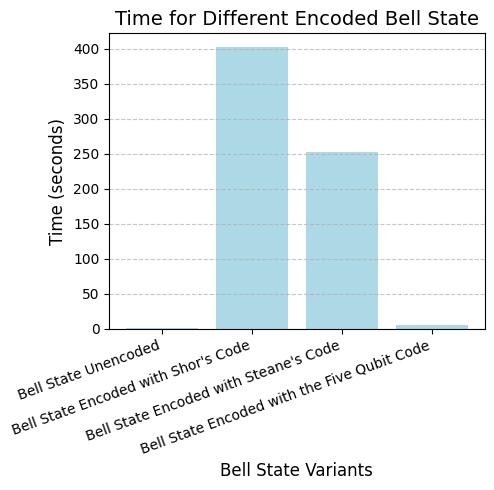

In [31]:
names = [list(item.keys())[0] for item in time]
times = [list(item.values())[0] for item in time]

# Plot the bar chart
plt.figure(figsize=(5, 5))  # Adjust size as needed
plt.bar(names, times, color='lightblue')


# Add labels and title
plt.xlabel('Bell State Variants', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time for Different Encoded Bell State', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=10)  # Rotate labels for readability

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('Results/time.png')
plt.show()
plt.close()

<h3 style="color:white"> 
    Quantum Computer
</h3>

In [29]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=qBackend, optimization_level=3)
control_isa_circuit = pm.run(control_qc)
shor_isa_circuit = pm.run(shor_qc)
steane_isa_circuit = pm.run(steane_qc)
fqc_isa_circuit = pm.run(fqc_qc)

In [16]:
# Create a batch of jobs
with Batch(backend=qBackend):
    sampler = SamplerV2()
    
    #Run each circuit (maximum of three pending jobs, so I can only run these three, and then run the Five Qubit Code (I'm also running the Steane code after because debugging stuff)
    control_job = sampler.run(pubs=[control_isa_circuit], shots=1024)
    shor_job = sampler.run(pubs=[shor_isa_circuit], shots=1024)


print(f">>> Control Job ID: {control_job.job_id()}")
print(f">>> Shor Job ID: {shor_job.job_id()}")


>>> Control Job ID: cxyyjtby1ae0008nh2ng
>>> Shor Job ID: cxyyjtv3wrp0008m4fpg


In [17]:
#Get the results
control_result = control_job.result()
shor_result = shor_job.result()

RuntimeInvalidStateError: 'Unable to retrieve result for job cxyyjtv3wrp0008m4fpg. Job was cancelled.'

In [28]:
plot_histogram(control_result[0].data.c.get_counts(), filename="FinalResults/control.png")
plot_histogram(shor_result[0].data.c.get_counts(), filename="FinalResults/shor.png")

NameError: name 'control_result' is not defined

In [17]:
with Batch(backend=qBackend):
    sampler = SamplerV2()

    #Run the other two jobs
    steane_job = sampler.run(pubs=[steane_isa_circuit], shots=1024)
    fqc_job = sampler.run(pubs=[fqc_isa_circuit], shots=1024)

print(f">>> Steane Job ID: {steane_job.job_id()}")
print(f">>> Five Qubit Code Job ID: {fqc_job.job_id()}")

>>> Steane Job ID: cy07hbn6vek0008r8fkg
>>> Five Qubit Code Job ID: cy07hc5cw2k0008jct50


In [18]:
steane_result = steane_job.result()
fqc_result = fqc_job.result()

RuntimeJobFailureError: 'Unable to retrieve job result. Error code 6103; Internal OpenQASM3 compilation error'

In [88]:
plot_histogram(steane_result[0].data.measured_output.get_counts(), filename="FinalResults/steane.png")
#plot_histogram(fqc_result[0].data.measured_output.get_counts(), filename="FinalResults/fqc.png")

NameError: name 'steane_result' is not defined